<a href="https://colab.research.google.com/github/JiujiaZ/restless_bandit_basics/blob/edit/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some quick experiments to compare whittle index policy and random policy for a restless bandits, where each arm is a MDP.

In [5]:
import numpy as np
from matplotlib import pyplot as plt

from tools import random_transitions
from models import Restless_Bandit
from train import *


#### Assume knowing exact transition

In [2]:
n_arms = 100
n_states = 5
n_transitions = 2
K = 2
R = np.array([0, 1, 0, 0, -1])

transitions_indx = np.random.choice(n_transitions, size = n_arms)

transitions = np.zeros((n_arms, 2, n_states, n_states))

for i in range(n_transitions):
    transitions[transitions_indx == i] = random_transitions(n_actions = 2, n_states = n_states)

init_states = np.zeros((n_arms, n_states))
indx = np.random.choice(n_states, size = n_arms)
init_states[np.arange(len(indx)), indx] = 1

In [3]:
rb = Restless_Bandit(transitions = transitions, initial_states = init_states, R = R)
WI_reward = WI_train(rb, R, episode = 1000, K = K )

rb = Restless_Bandit(transitions = transitions, initial_states = init_states, R = R)
random_reward = random_train(rb, episode = 1000, K = K )

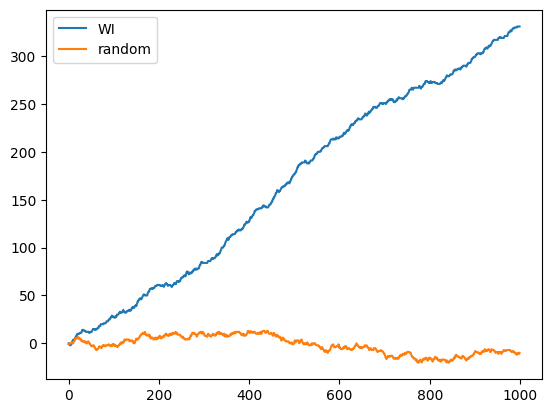

In [6]:
plt.plot(np.cumsum(WI_reward), label = 'WI')
plt.plot(np.cumsum(random_reward), label = 'random')
plt.legend()